# Bilinear least-squares estimation of episodic latent factors in inventory management

_J. True Merrill, Ph.D._

_Georgia Tech Research Institute_

Setting inventory stocking levels requires balancing the risk of depleting items before resupply with the costs of purchasing and maintaining stock. Achieving this balance requires comprehensive understanding of the risk model and item consumption patterns to inform optimal stocking and reordering strategies. Quantifying the risk of episodic events is especially challenging due to their unpredictable nature and the rapid shifts in usage patterns and correlations between item consumption rates. To address these challenges, planners need effective forecasting methods for predicting consumption demand during future episodes, as well as analytical techniques to uncover latent factors in historical data that correlate with past events.

We propose a straightforward method for extracting latent factors and their correlations with consumption rates through a weighted bilinear least-squares estimation. In this approach, time is divided into a sequence of $N$ discrete, independent intervals. The inventory system monitors $F$ distinct item types, with $X_{t,i}$​ representing the quantity of the $i$-th item type consumed during the $t$-th interval. We assume that consumption demand is influenced by a set of $R$ latent factors that vary over time and are not directly observable. Let $Y_{s, j}$ represent the value of the $j$-th latent factor at the $s$-th time step. The simplest way to model the coupling between these latent factors and the observed consumption data is through the linear model:

$$
    X_{t, i} = \sum_{j = 1}^{R} A_{i, j} Y_{t, j} + E_{t, i},
$$

where $E_{t, i}$ denotes the error in the linear model.  This equation can be expressed more concisely using matrix notation:

$$
    \mathbf{X} = \mathbf{A} \mathbf{Y}^T + \mathbf{E}
$$

where $\mathbf{X}$ is a $N \times F$ matrix of observed data, $\mathbf{A}$ is a $F \times R$ matrix of coupling coefficients, and $\mathbf{Y}$ is a $N \times R$ matrix describing the latent variables a each time step.  $\mathbf{E}$ is a $N \times F$ matrix of errors.

Our goal is to decompose a known matrix of data $\mathbf{X}$ into the product of two lower-rank matrices $\mathbf{A}$ and $\mathbf{Y}$ such that the Frobenius norm $|| \mathbf{X} - \mathbf{A} \mathbf{Y}^T ||_F$ is minimized.  This can be accomplished by a bilinear least squares optimization which iteratively solves for the coefficient matrix and latent factors that together minimize the Frobenius norm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Example dataset

To illustrate this technique, we will generate an example dataset. First, we will discretize time into $N$ distinct intervals. We then define the $R$ latent factors; in this example, there is a single latent factor represented by the time series $Y_t = A t \exp(-t)$. By convention, we will normalize the latent factors such that $\sum_t^N || Y_t ||^2 = 1$. Next, we construct a coefficient matrix that maps the latent factors to a data space comprising five distinct item types. To reflect real-world systems where noise is present and $X_{t,i}$ typically represents a non-negative integer count of consumed units, we will sample $X_{t,i}$ from a Poisson distribution with the parameter $\lambda_{t,i} = (\mathbf{A} \mathbf{Y}^T)_{t, i}$.

In [2]:
# Discritize time
t = np.arange(11)

# Create the true latent factor matrix and normalize each column 
Y = np.array(t * np.exp(-t)).reshape((-1, 1))
Y = Y / np.linalg.norm(Y)

# Create the true coefficient matrix
A = np.array([
    [0.95], 
    [3],
    [50],
    [0.5],
    [22]
])

# Create the noisy data by sampling from the Poisson distribution
X = np.random.poisson(A @ Y.T)


The plot below shows the noisy inventory data as a time series.

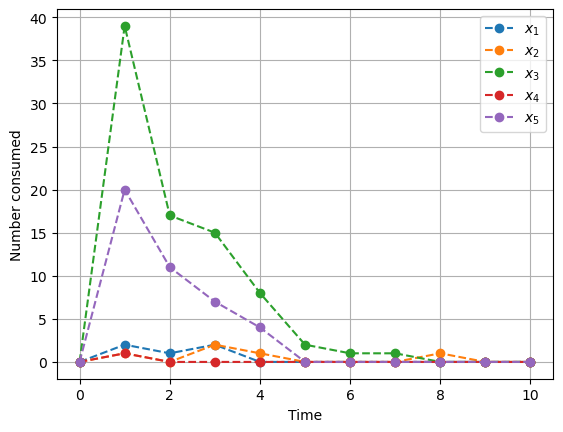

In [3]:
plt.plot(t, X[0, :], marker='o', linestyle='--', label=r'$x_1$')
plt.plot(t, X[1, :], marker='o', linestyle='--', label=r'$x_2$')
plt.plot(t, X[2, :], marker='o', linestyle='--', label=r'$x_3$')
plt.plot(t, X[3, :], marker='o', linestyle='--', label=r'$x_4$')
plt.plot(t, X[4, :], marker='o', linestyle='--', label=r'$x_5$')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Number consumed')
plt.legend()

plt.grid(True)
plt.show()

Next, using only the noisy data, we use bilinear least squares to recover estimates for the coefficient matrix $\mathbf{A}$ and latent factors $\mathbf{Y}$.  I've implemented a robust bilinear least squares algorithm in a small package distributed with this notebook.

In [4]:
from bls_predict import bilinear_least_squares

result = bilinear_least_squares(X, rank=1)

# Normalize each of the columns of Y so their L2-norm is exactly 1.  A is
# scaled accordingly so that the product $A Y^T$ does not change.
result.normalize()

Now that we have a solution, we should check how closely the estimate $\mathbf{\tilde{Y}}$ approximates its true values.  The standard measure of "closeness" between matrices is the Frobenius norm $|| \mathbf{M} ||_F = \sqrt{ \textrm{Tr} (M M^T) }$.  Below we calculate the Frobenius norms of the difference $|| \mathbf{\tilde{Y}} - \mathbf{Y} ||_F$.

In [5]:
from IPython.display import Markdown, display

def array_to_latex(matrix):
    latex_str = r"\begin{bmatrix}"
    def format_data(x):
        return f"{x:.4f}"
    for row in matrix:
        latex_str += " & ".join(map(format_data, row)) + r" \\ "
    latex_str += r"\end{bmatrix}"
    return latex_str

def frobenius_norm(M):
    return float(np.linalg.norm(M, "fro"))


Y_norm = frobenius_norm(result.Y - Y)
display(
    Markdown(
        r"$\mathbf{\tilde{Y}} - \mathbf{Y} = " + array_to_latex(result.Y - Y) + r"$"
    )
)
display(Markdown(r"$|| \mathbf{\tilde{Y}} - \mathbf{Y} ||_F = " + f"{Y_norm:.4f}" + r"$"))

$\mathbf{\tilde{Y}} - \mathbf{Y} = \begin{bmatrix}-0.0000 \\ 0.0907 \\ -0.1666 \\ 0.0147 \\ 0.0222 \\ -0.0351 \\ -0.0135 \\ 0.0039 \\ -0.0049 \\ -0.0023 \\ -0.0009 \\ \end{bmatrix}$

$|| \mathbf{\tilde{Y}} - \mathbf{Y} ||_F = 0.1953$

Next, we plot $\mathbf{\tilde{Y}}$ and $\mathbf{Y}$ as time series.

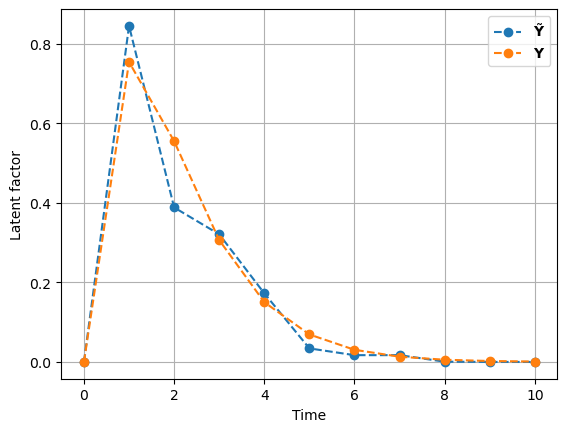

In [6]:
plt.plot(t, result.Y, marker='o', linestyle='--', label=r'$\mathbf{\tilde{Y}}$')
plt.plot(t, Y, marker='o', linestyle='--', label=r'$\mathbf{Y}$')
plt.xlabel('Time')
plt.ylabel('Latent factor')
plt.legend()
plt.grid(True)
plt.show()

Bilinear least squares has done a good job recovering the hidden latent factor from the observed inventory data.  Finally, let's check how close the decomposition came to fitting the noisy data.  The error matrix can be computed as $\mathbf{E} = \mathbf{X} - \mathbf{\tilde{A}} \mathbf{\tilde{Y}}^T$.  The error matrix is printed below.

In [7]:
X_approx = result.A @ result.Y.T
E = X - X_approx
E_norm = frobenius_norm(E)

display(Markdown(r"$\mathbf{E} = " + array_to_latex(E) + r"$"))
display(Markdown(r"$|| \mathbf{E} ||_F = " + f"{E_norm:.4f}" + r"$"))

$\mathbf{E} = \begin{bmatrix}0.0000 & -0.3001 & -0.0574 & 1.1264 & -0.4693 & -0.0926 & -0.0463 & -0.0463 & -0.0017 & 0.0000 & 0.0000 \\ 0.0000 & -0.4035 & -0.6452 & 1.4670 & 0.7136 & -0.0565 & -0.0282 & -0.0282 & 0.9990 & 0.0000 & 0.0000 \\ 0.0000 & 0.2295 & -0.8235 & 0.2752 & 0.0886 & 0.4395 & 0.2197 & 0.2197 & -0.0282 & 0.0000 & 0.0000 \\ 0.0000 & 0.2855 & -0.3285 & -0.2713 & -0.1458 & -0.0288 & -0.0144 & -0.0144 & -0.0005 & 0.0000 & 0.0000 \\ 0.0000 & -0.3848 & 1.6287 & -0.7420 & -0.1596 & -0.8205 & -0.4102 & -0.4102 & -0.0149 & 0.0000 & 0.0000 \\ \end{bmatrix}$

$|| \mathbf{E} ||_F = 3.4082$

## Multiple latent factors

As a second more complex example, consider a case where there are two latent factors:

$$
Y_{t,1} = A_1 t \exp(- \gamma t)
$$
$$
Y_{t,2} = A_2 G_t
$$

where $G_t$ is zero if $t$ is equal to a multiple of 7 or one less than a multiple of seven and one otherwise.  The normalization constants $A_1$ and $A_2$ are chosen so that over the entire time window $\sum_t^N Y_{t, i} = 1$.  The latent factor $Y_{t, 1}$ represents a process that surges suddently and slowly ramps down over time.  This factor could represent a sudden demand surge created by an outbreak.  The latent factor $Y_{t, 2}$ represents a process with constant demand over a five day work-week, with zero demand over the two day weekend.  Both of these processes occur simultaneously.  Next, we construct a coefficient matrix that maps the latent factors to a data space comprising five distinct item types.  Finally, we will add noise by sampling  $X_{t,i}$ from a Poisson distribution with the parameter $\lambda_{t,i} = (\mathbf{A} \mathbf{Y}^T)_{t, i}$.

In [8]:
# Discritize time
t = np.arange(21)
gamma = 0.25

def g(t):
    result = np.ones(shape=t.shape)
    mask = (t%7 == 0) + (t%7 == 6)
    result[mask] = 0
    return result

# Create the true latent factor matrix and normalize each column 
Y = np.array([t * np.exp(-gamma * t), g(t)]).T
Y[:, 0] = Y[:, 0] / np.linalg.norm(Y[:, 0])
Y[:, 1] = Y[:, 1] / np.linalg.norm(Y[:, 1])


# Create the true coefficient matrix
A = 5 * np.array([
    [0.95, 0.3], 
    [3, 5],
    [50, 0],
    [0.5, 0.5],
    [2, 20]
])

# Create the noisy data by sampling from the Poisson distribution
X = np.random.poisson(A @ Y.T)

The plot below shows the noisy inventory data as a time series.  Because of the second latent factor with confounding dynamics, its much harder now to see the underlying structure in the data.

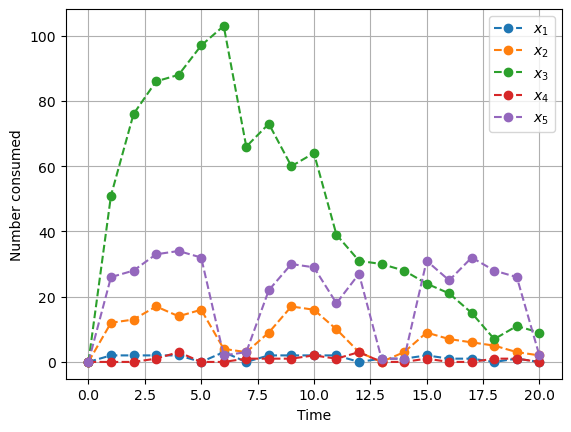

In [9]:
plt.plot(t, X[0, :], marker='o', linestyle='--', label=r'$x_1$')
plt.plot(t, X[1, :], marker='o', linestyle='--', label=r'$x_2$')
plt.plot(t, X[2, :], marker='o', linestyle='--', label=r'$x_3$')
plt.plot(t, X[3, :], marker='o', linestyle='--', label=r'$x_4$')
plt.plot(t, X[4, :], marker='o', linestyle='--', label=r'$x_5$')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Number consumed')
plt.legend()

plt.grid(True)
plt.show()

Next, we use bilinear least squares to solve for the unknown latent factors plot $\mathbf{\tilde{Y}}$ and $\mathbf{Y}$ as time series.

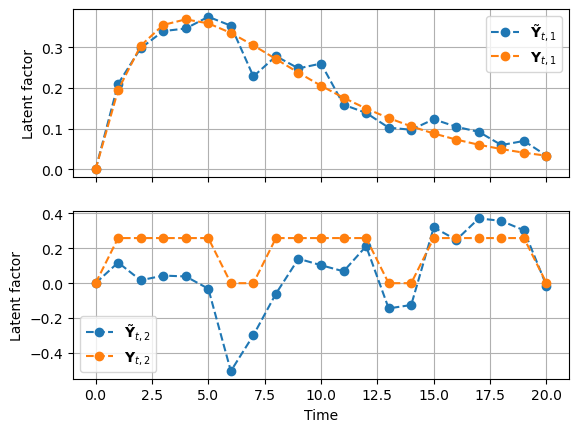

In [10]:
result = bilinear_least_squares(X, rank=2)

# Normalize each of the columns of Y so their L2-norm is exactly 1.  A is
# scaled accordingly so that the product $A Y^T$ does not change.
result.normalize()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, result.Y[:, 0], marker='o', linestyle='--', label=r'$\mathbf{\tilde{Y}}_{t,1}$')
ax1.plot(t, Y[:, 0], marker='o', linestyle='--', label=r'$\mathbf{Y}_{t,1}$')
ax1.legend()
ax1.grid(True)
ax1.set_ylabel('Latent factor')

ax2.plot(t, result.Y[:, 1], marker='o', linestyle='--', label=r'$\mathbf{\tilde{Y}}_{t,2}$')
ax2.plot(t, Y[:, 1], marker='o', linestyle='--', label=r'$\mathbf{Y}_{t,2}$')
ax2.legend()
ax2.grid(True)
ax2.set_xlabel('Time')
ax2.set_ylabel('Latent factor')

plt.show()